# Analysing Player Swaps

Note: still in progress.

This notebook is to wrangle football lineup and player availalibity data and explore the underlying patterns in player replacements (substitutions, rotations, etc.) can reveal player similarity. This may help us in future to predict future lineups given player availabity.

# Step 1: Load and Transform Data

Load player data.

In [1]:
# Import
import os
os.chdir('/workspaces/codespaces-jupyter/')
from src.core.ETL import FPL_data
from src.core.predict import players_short_term_trends
import pandas as pd
import numpy as np

# Load snapshot
snapshot = 'present'
FPL = FPL_data.pipeline(offline=True, raw_data_location=snapshot)
FPL.load_all()

# Load all player data
source_df = players_short_term_trends.get_player_match_data(FPL, ['22-23', '21-22'])

# Display example record
source_df.iloc[0]

/workspaces/codespaces-jupyter/src/core/predict/players_short_term_trends.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  absences['tm_code'] = absences.groupby(['tm_name', 'team']).ngroup()


Name                     Aké Nathan Aké (Manchester City, Defender)
Team                                                            MCI
Starts                                                            1
Mins                                                           90.0
On                                                              0.0
Off                                                             0.0
Vs                                                              WHU
GW                                                              1.0
Date                                            2022-08-07 00:00:00
Home                                                          False
RC                                                              0.0
xA                                                             0.01
xG                                                             0.04
Pen Goals                                                       0.0
season                                          

There are some players from relegated that we are not evaulating. Their IDs are not included and we need unique dummy IDs for easier self-joins.

There are four types of swaps: substitutions, rotations (of starting eleven), reserve replaces unavailable starter, and recently available starter replaces reserve.

We need data suitable for finding swaps: starts, substitions (on and off), minutes (to narrow down sub swaps) and availability.

In [2]:
df = source_df[['element', 'Name', 'tm_code', 'team', 'kickoff_time', 'Starts', 'On', 'Off', 'Available', 'Mins', 'Team', 'Vs', 'RC', 'status', 'season']]

Generate code for matchups (to filter for specific matches)

In [3]:
def generate_code(row):
    sorted_pair = sorted([row['Team'], row['Vs']])
    return '-'.join(sorted_pair)

# Generate codes
matchup_cols = ['kickoff_time', 'Team', 'Vs']
code_lu = df[matchup_cols].drop_duplicates().dropna()
code_lu['matchup_code'] = code_lu.apply(generate_code, axis=1)
code_lu['matchup_code'] = code_lu['matchup_code'].astype('category').cat.codes

# Add to df
df = df.merge(code_lu, on=matchup_cols, how='left', suffixes=[None, '_drop'])

code_lu

,kickoff_time,Team,Vs,matchup_code
0,2022-08-07,MCI,WHU,208
16,2022-08-07,WHU,MCI,208
32,2022-08-07,BHA,MUN,54
43,2022-08-07,BRE,LEI,85
44,2022-08-07,LEI,BRE,85
...,...,...,...,...
19264,2021-09-25,BRE,LIV,86
19499,2021-09-18,BRE,WOL,96
19649,2021-09-11,BRE,BHA,44
19831,2021-08-28,BRE,AVL,24


Check data is correct.

In [4]:
# No data for players that play 0 mins in given data source
zero_cols = ['On', 'Off', 'Mins', 'RC']
df[zero_cols] = df[zero_cols].fillna(0)
one_cols = ['Available']
df[one_cols] = df[one_cols].fillna(1)

# Fill season column using dates
mapper = df[['kickoff_time', 'season']].dropna().drop_duplicates()
mapper = mapper.set_index('kickoff_time')['season']
df['season'] = df['kickoff_time'].map(mapper)

# df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56422 entries, 0 to 56421
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   element       41537 non-null  float64       
 1   Name          21831 non-null  object        
 2   tm_code       52174 non-null  float64       
 3   team          54852 non-null  float64       
 4   kickoff_time  56422 non-null  datetime64[ns]
 5   Starts        56422 non-null  int64         
 6   On            56422 non-null  float64       
 7   Off           56422 non-null  float64       
 8   Available     56422 non-null  float64       
 9   Mins          56422 non-null  float64       
 10  Team          56422 non-null  object        
 11  Vs            56422 non-null  object        
 12  RC            56422 non-null  float64       
 13  status        52174 non-null  category      
 14  season        56422 non-null  object        
 15  matchup_code  56422 non-null  int16 

In [5]:
# Correct data types
df = df.astype({'Starts':'bool', 'Available':'bool', 'On':'bool', 'Off':'bool', 'Mins':'int64'
                , 'Team':'category', 'Vs':'category', 'element':'Int64', 'team':'Int64', 'RC':'bool'
                , 'tm_code':'Int64', 'season':'category'})

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56422 entries, 0 to 56421
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   element       41537 non-null  Int64         
 1   Name          21831 non-null  object        
 2   tm_code       52174 non-null  Int64         
 3   team          54852 non-null  Int64         
 4   kickoff_time  56422 non-null  datetime64[ns]
 5   Starts        56422 non-null  bool          
 6   On            56422 non-null  bool          
 7   Off           56422 non-null  bool          
 8   Available     56422 non-null  bool          
 9   Mins          56422 non-null  int64         
 10  Team          56422 non-null  category      
 11  Vs            56422 non-null  category      
 12  RC            56422 non-null  bool          
 13  status        52174 non-null  category      
 14  season        56422 non-null  category      
 15  matchup_code  56422 non-null  int16 

In [6]:
def fill_id(grp):
    return grp.apply(lambda x: x.fillna(x.dropna().unique()[0]) if x.nunique() == 1 
                          else x.fillna(np.nan))

# Make every ('element', 'Name', 'tm_code') triplet identical by filling
# in the blanks we can
id_cols = ['element', 'Name', 'tm_code']
for col in id_cols + id_cols[1::-1]:
    q = ~df[col].isnull()
    grps = df.loc[q, id_cols].groupby(col, group_keys=False)    
    df.loc[q, id_cols] = grps.apply(fill_id)

# Assign to a new unique id 
df.insert(0, 'player', df[id_cols].fillna(-1).groupby(id_cols).ngroup())

In [7]:
# Test the new id 
for col in id_cols:
    assert df[col].nunique() == len(df[[col, 'player']].dropna().drop_duplicates().index)
    print(f"There is one player_id for every '{col}' id.")
assert len(df.index) == len(df.player.dropna())
print("Every row has a player id.")

There is one player_id for every 'element' id.
There is one player_id for every 'Name' id.
There is one player_id for every 'tm_code' id.
Every row has a player id.


In [8]:
# Drop unneeded player id columns
df.drop(columns=['Name', 'tm_code'], inplace=True)

df.sample(10)

,player,element,team,kickoff_time,Starts,On,Off,Available,Mins,Team,Vs,RC,status,season,matchup_code
50615,673,164,7,2022-04-30,False,False,False,True,0,CRY,SOU,False,a,21-22,138
29334,667,158,7,2023-03-15,False,False,False,True,0,CRY,BHA,False,b,22-23,47
24695,1217,745,2,2023-04-30,False,False,False,True,0,AVL,MUN,False,a,22-23,34
32471,1022,547,11,2022-10-16,False,False,False,False,0,LEE,ARS,False,u,22-23,9
46142,238,<NA>,5,2022-02-26,False,False,False,False,0,BHA,AVL,False,i,21-22,22
28609,657,147,6,2023-05-02,False,False,False,True,0,CHE,ARS,False,b,22-23,5
6841,711,205,9,2022-10-15,True,False,False,True,90,FUL,BOU,False,s,22-23,67
29760,1152,678,8,2022-09-18,False,False,False,False,0,EVE,WHU,False,u,22-23,155
6365,1051,577,8,2022-10-09,True,False,False,True,90,EVE,MUN,False,s,22-23,148
17572,857,363,15,2021-12-12,True,False,False,True,90,NEW,LEI,False,s,21-22,183


In [9]:
# Check no missing sub data by checking that there are equal numbers of 
# subs off and subs on in each game
tmp = df.groupby(['Team', 'kickoff_time'])[['Off', 'On']].sum()
tmp.loc[tmp.Off != tmp.On]

,,Off,On
Team,kickoff_time,,


In [10]:
# Add some ID columns for easier management of data
df['group'] = df[['Team', 'kickoff_time']].apply(tuple,axis=1).rank(method='dense').astype('int64')

len(df[['group', 'player']].drop_duplicates().index)

56422

The following are several function to complete the complicated task of working out which players were subbed for one another using only FPL's definition of minutes, starts, subs on and subs off.

In [11]:
def append_elements(A, B, append_once=False, appended=None, states=None):
    """
    This function appends elements from list B to each sublist in list A. 
    If append_once is True, each element from B is appended only once to a sublist in A.
    If append_once is False, each element from B can be appended multiple times to sublists in A.
    
    Parameters:
    A (list): A list of lists.
    B (list): A list of elements to be appended to sublists in A.
    append_once (bool): If True, each element from B is appended only once to a sublist in A.
    appended (list): A list of boolean values indicating whether an element from B has been appended to a sublist in A.
    states (list): A list to store the states.
    
    Returns:
    states (list): A list of lists with players from B appended to sublists in A.
    """
    # Initialize states and appended if they are None
    if states is None:
        states = []
    if appended is None:
        appended = [False]*len(A)
        
    # Iterate over each sublist in A and B
    for i in range(len(A)):
        for j in range(len(B)):
            # Check if this player of A has been appended to
            if not appended[i] or not append_once:  
                # Create a new version of A with the current player of B appended to the current sublist
                new_A = A[:i] + [A[i]+[B[j]]] + A[i+1:]
                # Create a new version of B without the current element
                new_B = B[:j] + B[j+1:]
                # Mark this element as appended to
                new_appended = appended[:i] + [True] + appended[i+1:]  
                # If there are still elements in B, recursively call the function
                if new_B:
                    append_elements(new_A, new_B, append_once, new_appended, states)
                # If there are no more elements in B, add the new version of A to the states
                else:
                    states.append(new_A)

    # If no elements were appended, add the original version of A to the states
    if len(states) == 0:
        states = [A]

    return states


# Test
A = [["a"], ["b"], ["c"]]
B = ["1", "2"]
states = append_elements(A, B, append_once=False)
for state in states:
    print(state)

[['a', '1', '2'], ['b'], ['c']]
[['a', '1'], ['b', '2'], ['c']]
[['a', '1'], ['b'], ['c', '2']]
[['a', '2', '1'], ['b'], ['c']]
[['a', '2'], ['b', '1'], ['c']]
[['a', '2'], ['b'], ['c', '1']]
[['a', '2'], ['b', '1'], ['c']]
[['a'], ['b', '1', '2'], ['c']]
[['a'], ['b', '1'], ['c', '2']]
[['a', '1'], ['b', '2'], ['c']]
[['a'], ['b', '2', '1'], ['c']]
[['a'], ['b', '2'], ['c', '1']]
[['a', '2'], ['b'], ['c', '1']]
[['a'], ['b', '2'], ['c', '1']]
[['a'], ['b'], ['c', '1', '2']]
[['a', '1'], ['b'], ['c', '2']]
[['a'], ['b', '1'], ['c', '2']]
[['a'], ['b'], ['c', '2', '1']]


In [12]:
def combine_states(states):
    """
    This function combines the states by sorting the inner lists and converting them to tuples.
    It then adds these tuples to a set to remove any duplicates.
    
    Parameters:
    states (list): A list of lists representing different states.
    
    Returns:
    combined_states (list): A list of tuples representing the combined states.
    """
    # Initialize an empty set to store the combined states
    combined_states = set()
    
    # Iterate over each result
    for state in states:
        # Convert inner lists to tuples and sort them before adding to the set
        sorted_state = tuple(sorted(tuple(i) for i in state))  
        combined_states.add(sorted_state)
    
    # Convert the set back to a list before returning
    return list(combined_states)


# Call the function with the results from the previous function
combine_states(states)

[(('a',), ('b',), ('c', '2', '1')),
 (('a',), ('b',), ('c', '1', '2')),
 (('a', '1'), ('b',), ('c', '2')),
 (('a', '1'), ('b', '2'), ('c',)),
 (('a',), ('b', '1'), ('c', '2')),
 (('a',), ('b', '1', '2'), ('c',)),
 (('a', '1', '2'), ('b',), ('c',)),
 (('a',), ('b', '2', '1'), ('c',)),
 (('a', '2', '1'), ('b',), ('c',)),
 (('a', '2'), ('b',), ('c', '1')),
 (('a',), ('b', '2'), ('c', '1')),
 (('a', '2'), ('b', '1'), ('c',))]

In [13]:
def map_to_mins(states, mins_mapper, sent_off):
    """
    This function maps states to their corresponding minutes and calculates the variance of the total minutes.
    It also separates the combinations into two categories: 'full' and 'on_RC' based on whether any player in the combination is in the 'sent_off' list.
    
    Parameters:
    states (list): A list of states where each state is a list of combinations and each combination is a list of players.
    mins_mapper (dict): A dictionary mapping players to their corresponding minutes.
    sent_off (list): A list of players that are sent off.
    
    Returns:
    state_dicts (list): A list of dictionaries where each dictionary represents a state and contains the state, the combinations and their total minutes, and the variance of the total minutes for 'full' combinations.
    """
    state_dicts = []
    for state in states:
        state_dict = {}
        state_dict['full'] = {}
        state_dict['on_RC'] = {}
        state_dict['state'] = state

        full_totals = []
        on_RC_totals = []
        full_combos = []
        on_RC_combos = []
        full_fh_capped = []
        full_sh_capped = []
        for combination in state:
            # Get total minutes for combination
            mins = []
            for player in combination:
                player_mins = mins_mapper[player]
                mins.append(player_mins)

            # Initialise conditions
            fh_capped = False
            sh_capped = False

            # If starting player plays second half
            if mins[0] == 90:
                fh_capped = True
                sh_capped = True
            elif mins[0] >= 45:
                fh_capped = True

            # If finishing player maximises second half minutes
            if mins[-1] == 90:
                fh_capped = True
                sh_capped = True
            elif mins[-1] >= 45:
                sh_capped = True

            # If middle players might have absorbed minutes
            for i, player_mins in enumerate(mins[1:-1], 1):
                if player_mins == 90:
                    fh_capped = True
                    sh_capped = True
                elif player_mins >= 45:
                    minute_on = np.sum(mins[:i])
                    if minute_on < 11:
                        fh_capped = True
                    elif minute_on >= 45:
                        sh_capped = True

            # Calcalute total mins of combination
            total = np.sum(mins)
            
            # Add to relevant list based on whether any player in the combination is in the 'sent_off' list
            if any(player in combination for player in sent_off):
                on_RC_totals.append(total)
                on_RC_combos.append(combination)
            else:
                full_totals.append(total)
                full_combos.append(combination)
                full_fh_capped.append(fh_capped)
                full_sh_capped.append(sh_capped)

        # Calculate variance of full totals (correct matches should sum to the same total)
        state_dict['full']['var'] = np.round(np.var(full_totals), 4)

        # Add totals and combinations to state dictionary
        state_dict['full']['combos'] = full_combos
        state_dict['on_RC']['combos'] = on_RC_combos
        state_dict['full']['totals'] = full_totals
        state_dict['on_RC']['totals'] = on_RC_totals
        state_dict['full']['fh_capped'] = full_fh_capped
        state_dict['full']['sh_capped'] = full_sh_capped

        state_dicts.append(state_dict)

    # The function returns a list of dictionaries where each dictionary represents a state
    return state_dicts


# Preview
states = [((5, 6), (7, 1), (10, 4)), ((5, 4), (7, 1), (10, 6)), 
          ((5, 4), (7, 6), (10, 1)), ((5, 6), (7, 4), (10, 1)), 
          ((5, 1), (7, 6), (10, 4)), ((5, 1), (7, 4), (10, 6))]
mins_mapper = {1: 38, 4: 25, 5: 70, 6: 16, 7: 63, 10: 58}
sent_off = [6]

state_dicts = map_to_mins(states, mins_mapper, sent_off)
for state_dict in state_dicts:
    print(state_dict)

{'full': {'var': 81.0, 'combos': [(7, 1), (10, 4)], 'totals': [101, 83], 'fh_capped': [True, True], 'sh_capped': [False, False]}, 'on_RC': {'combos': [(5, 6)], 'totals': [86]}, 'state': ((5, 6), (7, 1), (10, 4))}
{'full': {'var': 9.0, 'combos': [(5, 4), (7, 1)], 'totals': [95, 101], 'fh_capped': [True, True], 'sh_capped': [False, False]}, 'on_RC': {'combos': [(10, 6)], 'totals': [74]}, 'state': ((5, 4), (7, 1), (10, 6))}
{'full': {'var': 0.25, 'combos': [(5, 4), (10, 1)], 'totals': [95, 96], 'fh_capped': [True, True], 'sh_capped': [False, False]}, 'on_RC': {'combos': [(7, 6)], 'totals': [79]}, 'state': ((5, 4), (7, 6), (10, 1))}
{'full': {'var': 16.0, 'combos': [(7, 4), (10, 1)], 'totals': [88, 96], 'fh_capped': [True, True], 'sh_capped': [False, False]}, 'on_RC': {'combos': [(5, 6)], 'totals': [86]}, 'state': ((5, 6), (7, 4), (10, 1))}
{'full': {'var': 156.25, 'combos': [(5, 1), (10, 4)], 'totals': [108, 83], 'fh_capped': [True, True], 'sh_capped': [False, False]}, 'on_RC': {'combos':

In [14]:
def filter_states(state_dicts, full_thres=90, max_mins=135):
    """
    Filters a list of state dictionaries based on certain conditions.
    
    Parameters:
    state_dicts (list): A list of dictionaries, each representing a state.
    full_thres (int): The minimum threshold for full totals. Defaults to 90.
    max_mins (int): The maximum limit for all totals. Defaults to 135.
    
    Returns:
    list: A list of valid state dictionaries that meet the conditions.
    """
    # Initialise result
    valid_states = []

    # Iterate over each state dictionary
    for state in state_dicts:
        full = state['full']
        if correct_with_cap(full):
            valid_states.append(state)

    # Calculate the minimum variance from the full totals of all state dictionaries
    min_var = np.min([state_dict['full']['var'] for state_dict in state_dicts])

    # Reassign lists of states
    state_dicts = valid_states
    valid_states = []

    # Iterate over each state dictionary
    for state_dict in state_dicts:
        full_totals = state_dict['full']['totals'] 
        on_RC_totals = state_dict['on_RC']['totals']
        full = state_dict['full']

        # Keep best aligned full totals, that no totals exceed the maximum of 135
        # and that all full totals are full (in case they cannot be aligned)
        if state_dict['full']['var'] > min_var:
            continue
        # elif not correct_with_cap(full):
        #     continue
        elif any(total > max_mins for total in full_totals + on_RC_totals):
            continue
        elif np.min(full_totals) < full_thres:
            continue
        else:
            valid_states.append(state_dict)

    # Return the list of valid state dictionaries
    return valid_states


def correct_with_cap(full, forgiveness=2):
    totals, fh_capped, sh_capped = full['totals'], full['fh_capped'], full['sh_capped']
    for i, total in enumerate(totals[:-1]):
        for j, next_total in enumerate(totals[i+1:], i+1):
            fh_equal = fh_capped[i] == fh_capped[j]
            sh_equal = sh_capped[i] == sh_capped[j]
            if total > next_total + forgiveness:
                if (fh_equal and sh_capped[i] and not sh_capped[j]) or \
                   (sh_equal and fh_capped[i] and not fh_capped[j]):
                    return False
            if total < next_total - forgiveness:
                if (fh_equal and sh_capped[j] and not sh_capped[i]) or \
                   (sh_equal and fh_capped[j] and not fh_capped[i]):
                    return False
    return True
        

# Filter previously generated dictionaries for best fit
for state_dict in filter_states(state_dicts):
    print(state_dict['state'])

((5, 4), (7, 6), (10, 1))


In [15]:
def find_pair_sets(states):
    """
    This function takes a list of states, where each state is a tuple of tuples.
    It finds all pairs of elements from left to right within each state.
    Then, it groups all right elements which share a left element and removes duplicates.
    After that, it groups all left elements which share a right element.
    Finally, it returns a list of sets, where each set contains two sets (left and right).
    
    :param states: A list of states, where each state is a tuple of tuples.
    :return: A list of sets, where each set contains two sets (left and right).
    """
    
    # Find left to right pairs
    pairs = []
    for state in states:
        pairs += [state[i][j:j+2] for i in range(len(state)) for j in range(len(state[i])-1)]

    # Group all rights which share a left
    l2r = {}
    for pair in pairs:
        if pair[0] not in l2r:
            l2r[pair[0]] = [pair[1]]
        else:
            l2r[pair[0]] += [pair[1]]
    
    # Remove duplicates
    for k, v in l2r.items():
        l2r[k] = list(sorted(set(v)))

    # Sort dictionary of lists from largest to smallest
    l2r = {k: v for k, v in sorted(l2r.items(), key=lambda item: len(item[1]), reverse=True)}

    # Coagulate those who interchanged at once
    pair_sets = []
    for k, v in l2r.items():
        k_used = False
        for pair_set in pair_sets:
            for value in v:
                if value in pair_set[1] and k not in pair_set[0]:
                    pair_set[0].append(k)
                    k_used = True
                    break
        if not k_used:
            pair_sets.append([[k], v])

    return pair_sets


states = [((3, 7), (5, 9), (12, 2), (13, 4), (14, 15)), 
          ((3, 9), (5, 7), (12, 2), (13, 4), (14, 15)), 
          ((3, 9), (5, 4), (12, 2), (13, 7), (14, 15)), 
          ((3, 7), (5, 4), (12, 2), (13, 9), (14, 15))]

for pair_set in find_pair_sets(states):
    print(pair_set)

[[5, 13, 3], [4, 7, 9]]
[[12], [2]]
[[14], [15]]


In [16]:
def flex_match(grp):
    """
    This function takes a group of players and determines the substitutions made in the match. It 
    first separates the players into those who did not start or finish the match, those who started
    and came off, and those who came on and finished. It then generates all possible substitution 
    states and filters out those that do not meet the constraints. Finally, it returns the group with 
    an additional column indicating which players belong to which set of substitutions.

    Parameters:
    grp (DataFrame): A DataFrame containing information about a group of players, including whether 
    they start or finish the match and the number of minutes they play.

    Returns:
    grp (DataFrame): The input DataFrame with an additional column indicating which players belong to
    which set of substitutions.
    """
    # Set temporary index
    old_index = grp.index
    grp = grp.reset_index()

    # Separate players into those who start and finish the match, those who only start, and those 
    # who only finish
    both = grp.loc[grp.Off & grp.On]
    off = grp.loc[grp.Off & (~grp.On)]
    on = grp.loc[grp.On & (~grp.Off)]
    on_RC = on.loc[on.RC]

    # Check that there were any subs
    if len(off.index) == 0:
        grp['sub_grp_off'] = pd.NA
        grp['sub_grp_on'] = pd.NA
        grp.index = old_index
        return grp

    # Generate all possible substitution states for players who will come on then off
    state = [[player] for player in off.index]
    middle = both.index.to_list()
    states = append_elements(state, middle, append_once=False)
    states = combine_states(states)  # remove redundancies
    states = [list(list(j) for j in i) for i in states]

    # Generate all possible substitution states for players who will finish the match
    last = on.index.to_list()
    final_states = []
    for state in states:
        final_states += append_elements(state, last, append_once=True)
    # states = final_states
    states = combine_states(final_states)

    # Map players to minutes played and get total minutes over players who subbed
    mapper = grp['Mins'].to_dict()
    state_dicts = map_to_mins(states, mapper, on_RC.index)

    # Filter for states which best align with constraints
    state_dicts = filter_states(state_dicts, full_thres=80, max_mins=135)

    # Extract pair sets (for simultaneous subs)
    states = [state_dict['state'] for state_dict in state_dicts]
    pair_sets = find_pair_sets(states)

    # Return in grp format, with a new column indicating which players belong to which set of subs
    for i, col in enumerate(['sub_grp_off', 'sub_grp_on']):
        for sub_grp, pair_set in enumerate(pair_sets, 1):
            grp.loc[pair_set[i], col] = sub_grp
        grp[col] = grp[col].astype('Int64')
    grp.index = old_index

    return grp


# Preview
grps = df.groupby('group', group_keys=False)
grp = flex_match(grps.get_group(436))
display_cols =  ['Team', 'kickoff_time', 'player', 'Starts', 'On', 
                 'Off', 'RC', 'Mins', 'sub_grp_on', 'sub_grp_off']
grp.loc[grp.On | grp.Off, display_cols]

,Team,kickoff_time,player,Starts,On,Off,RC,Mins,sub_grp_on,sub_grp_off
199,CHE,2023-01-12,373,False,True,False,False,41,2,<NA>
8902,CHE,2023-01-12,652,True,False,True,False,76,<NA>,1
8903,CHE,2023-01-12,569,False,True,False,False,19,1,<NA>
8904,CHE,2023-01-12,628,False,True,False,False,19,1,<NA>
8905,CHE,2023-01-12,658,False,True,False,False,18,1,<NA>
8906,CHE,2023-01-12,1135,True,False,True,False,76,<NA>,1
8909,CHE,2023-01-12,645,True,False,True,False,76,<NA>,1
8910,CHE,2023-01-12,653,True,False,True,False,77,<NA>,1
8912,CHE,2023-01-12,1090,True,False,True,False,54,<NA>,2
8913,CHE,2023-01-12,648,False,True,False,False,18,1,<NA>


In [17]:
def test_sub_grps():
    tmp_df = df.copy()
    for grp_num in range(1, 7):
        off_col = f'is_grp_num_{grp_num}_off'
        on_col = f'is_grp_num_{grp_num}_on'

        tmp_df[off_col] = tmp_df.sub_grp_off.fillna(0) == grp_num
        tmp_df[on_col] = tmp_df.sub_grp_on.fillna(0) == grp_num

        tmp = tmp_df.groupby('group')[[off_col, on_col]].sum()
        assert (tmp[off_col] != tmp[on_col]).sum() == 0, f"Sub group {grp_num} do not match for all games"
    print('Test successful.')

# Run and test.
df = grps.apply(flex_match)
test_sub_grps()

Test successful.


In [18]:
# Self join to compare players and exclude comparing players to themselves
mesh = df.merge(df, on=['group', 'Team', 'kickoff_time'])
mesh = mesh.loc[mesh.player_x != mesh.player_y]

mesh.sample(10)

,index_x,player_x,element_x,team_x,kickoff_time,Starts_x,On_x,Off_x,Available_x,Mins_x,...,Off_y,Available_y,Mins_y,Vs_y,RC_y,status_y,season_y,matchup_code_y,sub_grp_off_y,sub_grp_on_y
856359,18807,956,476,20,2021-10-23,True,False,False,True,90,...,True,True,83,LEE,False,s,21-22,179,2,<NA>
1271407,44008,529,5,1,2022-05-16,False,False,False,True,0,...,False,False,0,NEW,False,-,21-22,14,<NA>,<NA>
2092077,14461,831,333,14,2023-05-13,True,False,False,True,90,...,False,False,0,WOL,False,i,22-23,217,<NA>,<NA>
1199186,43797,183,<NA>,18,2022-05-01,False,False,False,False,0,...,False,False,0,LEI,False,-,21-22,187,<NA>,<NA>
989601,51664,1024,549,10,2021-09-11,False,False,False,False,0,...,False,False,0,MCI,False,u,21-22,181,<NA>,<NA>
2032516,38766,1000,522,18,2023-04-15,False,False,False,False,0,...,False,True,90,BOU,False,s,22-23,76,<NA>,<NA>
678833,42070,239,<NA>,17,2021-12-11,False,False,False,False,0,...,False,False,0,ARS,False,-,21-22,17,<NA>,<NA>
779073,18285,606,87,4,2021-11-20,True,False,True,True,59,...,False,True,90,NEW,False,s,21-22,89,<NA>,<NA>
1870403,36915,879,388,16,2023-03-17,False,False,False,True,0,...,False,False,0,NEW,False,u,22-23,218,<NA>,<NA>
1358718,31555,1207,735,10,2022-08-27,False,False,False,False,0,...,False,False,0,CHE,False,u,22-23,116,<NA>,<NA>


Now we calculate the number of times players swapped via substitutions.

In [19]:
# For player x being subbed off for y
q_off = (mesh.sub_grp_off_x == mesh.sub_grp_on_y)
q_on = (mesh.sub_grp_off_y == mesh.sub_grp_on_x)
mesh['swap_sub'] = q_off | q_on
mesh.loc[q_off, 'swap_sub_group'] = mesh.loc[q_off, 'sub_grp_off_x']
mesh.loc[q_on, 'swap_sub_group'] = mesh.loc[q_on, 'sub_grp_on_x']

# Display top 15 suboff swaps
def sum_and_sort(mesh, measure):
    return mesh.groupby(['player_x', 'player_y'])[measure].sum().sort_values(ascending=False)
sum_and_sort(mesh, 'swap_sub').head(15)

player_x  player_y
770       754         24
754       770         24
859       863         23
863       859         23
677       675         22
675       677         22
614       608         19
608       614         19
783       791         18
668       680         18
680       668         18
791       783         18
563       550         17
550       563         17
944       941         16
Name: swap_sub, dtype: Int64

In [20]:
mesh['both_available'] = mesh['Available_x'] * mesh['Available_y']


# Get proportion of mutually available games players swapped via substitution
def proportion_count(mesh, measure, sample, fillna=True):
    p_measure = f'p_{measure}'

    tmp = mesh.groupby(['player_x', 'player_y'])[[measure, sample]].sum()
    tmp[p_measure] = tmp[measure] / tmp[sample]
    
    if fillna:
        tmp[p_measure] = tmp[p_measure].fillna(0)
    
    return tmp[[measure, sample, p_measure]]


def disp_proportion_count(mesh, measure, sample, min_samples=2):
    tmp = proportion_count(mesh, measure, sample).sort_values(f'p_{measure}', ascending=False)
    return tmp.loc[tmp[sample] > min_samples].head(15)


disp_proportion_count(mesh, 'swap_sub', 'both_available')

,,swap_sub,both_available,p_swap_sub
player_x,player_y,,,
516,851,14,16,0.875
851,516,14,16,0.875
986,369,3,4,0.75
612,270,3,4,0.75
369,986,3,4,0.75
270,612,3,4,0.75
1167,554,14,19,0.736842
554,1167,14,19,0.736842
512,343,5,7,0.714286


Now let's find rotation swaps. This is defined by both players being available and the number of times they replace each other in the starting eleven according to chronological order.

In [21]:
mesh['pair_match_number'] = mesh.groupby(['player_x', 'player_y'])['kickoff_time'].rank().astype(int)

mesh = mesh.sort_values(['player_x', 'player_y', 'kickoff_time'])
mesh[['player_x', 'player_y', 'kickoff_time', 'pair_match_number']]

,player_x,player_y,kickoff_time,pair_match_number
1070991,0,13,2021-08-14,1
1037197,0,13,2021-08-21,2
1014797,0,13,2021-08-28,3
992187,0,13,2021-09-11,4
953144,0,13,2021-09-19,5
...,...,...,...,...
1954876,1250,1242,2023-04-30,34
2050866,1250,1242,2023-05-08,35
2091835,1250,1242,2023-05-13,36
2123890,1250,1242,2023-05-21,37


In [22]:
# Use pair match number column to self-join with the previous game for each player pair
mesh['pair_match_number_next'] = mesh['pair_match_number'] + 1
mesh = mesh.merge(mesh, left_on=['player_x', 'player_y', 'season_x', 'pair_match_number'],
                right_on=['player_x', 'player_y', 'season_x', 'pair_match_number_next'],
                suffixes=[None, '_last'], how='left')

mesh[['player_x', 'player_y', 
      'Starts_x', 'Starts_y', 'Starts_x_last', 'Starts_y_last', 
      'Available_x', 'Available_y', 'Available_x_last', 'Available_y_last']]

/home/codespace/.local/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
/home/codespace/.local/lib/python3.10/site-packages/IPython/core/formatters.py:344: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,player_x,player_y,Starts_x,Starts_y,Starts_x_last,Starts_y_last,Available_x,Available_y,Available_x_last,Available_y_last
0,0,13,False,False,NaN,NaN,True,True,NaN,NaN
1,0,13,False,False,False,False,True,True,True,True
2,0,13,False,False,False,False,True,True,True,True
3,0,13,False,False,False,False,True,False,True,True
4,0,13,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...
2127775,1250,1242,False,False,False,False,True,True,True,True
2127776,1250,1242,False,False,False,False,False,False,True,True
2127777,1250,1242,False,False,False,False,True,True,False,False
2127778,1250,1242,False,False,False,False,True,True,True,True


The players have swapped when both were available last game, both are available this game, one started last match and the other started this match.

In [23]:
mesh['still_both_available'] = (mesh['both_available'] * mesh['both_available_last']).fillna(0)
mesh['swap_rotate_off'] = mesh.still_both_available *\
                          (mesh.status_x_last == 's') * (mesh.status_y_last != 's') *\
                          (mesh.status_x != 's') * (mesh.status_y == 's')
mesh['swap_rotate_on'] = mesh.still_both_available *\
                          (mesh.status_x_last != 's') * (mesh.status_y_last == 's') *\
                          (mesh.status_x == 's') * (mesh.status_y != 's')
mesh['swap_rotate'] = (mesh['swap_rotate_off'] + mesh['swap_rotate_on']).fillna(0)

sum_and_sort(mesh, 'swap_rotate').head(15)

player_x  player_y
783       791         21
791       783         21
807       808         18
808       807         18
799       802         15
802       799         15
754       770         12
784       773         12
773       784         12
785       784         12
784       785         12
770       754         12
775       789         12
789       775         12
680       668         11
Name: swap_rotate, dtype: int64

In [24]:
disp_proportion_count(mesh, 'swap_rotate', 'still_both_available')

,,swap_rotate,still_both_available,p_swap_rotate
player_x,player_y,,,
1091,660,3,7,0.428571
660,1091,3,7,0.428571
1172,645,5,12,0.416667
645,1172,5,12,0.416667
74,832,2,5,0.400000
832,74,2,5,0.400000
922,221,5,13,0.384615
221,922,5,13,0.384615
1154,791,8,21,0.380952


Similar to substitutions, rotations have quite a high sample size and seems to be a promising indicator of player pair interchangeability.

Now let's consider the cases where availability changes, with changes to the starting eleven. The case where a starting player becomes unavailable is reletivey simple. The case where a player becomes available again is less clear, as it can take more than one game for a starter to return to the starting eleven - they often make just a cameo to begin in the first game.

In [25]:
# Both to one available column
mesh['both_to_x_available'] = (mesh['Available_x'] * (1-mesh['Available_y']) * mesh['both_available_last'])
mesh['both_to_y_available'] = (mesh['Available_y'] * (1-mesh['Available_x']) * mesh['both_available_last'])
mesh['both_to_one_available'] = (mesh['both_to_x_available'] + mesh['both_to_y_available']).fillna(0)

# Find downgrade case
mesh['swap_downgrade_off'] = (mesh.status_x_last == 's') * (mesh.status_y_last != 's') *\
                             mesh['both_to_y_available'] * (mesh.status_y == 's')
mesh['swap_downgrade_on'] = (mesh.status_y_last == 's') * (mesh.status_x_last != 's') *\
                             mesh['both_to_x_available'] * (mesh.status_x == 's')
mesh['swap_downgrade'] = (mesh['swap_downgrade_off'] + mesh['swap_downgrade_on']).fillna(0)

sum_and_sort(mesh, 'swap_downgrade').head(15)

player_x  player_y
645       656         4
532       812         4
656       645         4
649       647         4
647       649         4
812       532         4
645       647         3
830       10          3
630       617         3
645       643         3
778       775         3
775       778         3
778       777         3
          781         3
645       655         3
Name: swap_downgrade, dtype: int64

In [26]:
disp_proportion_count(mesh, 'swap_downgrade', 'both_to_one_available')

,,swap_downgrade,both_to_one_available,p_swap_downgrade
player_x,player_y,,,
1097,910,3,3,1.00
910,1097,3,3,1.00
812,532,4,5,0.80
532,812,4,5,0.80
1092,713,3,4,0.75
775,789,3,4,0.75
624,630,3,4,0.75
646,657,3,4,0.75
835,10,3,4,0.75


In [27]:
# One to both available column
mesh['x_to_both_available'] = (mesh['Available_x_last'] * (1-mesh['Available_y_last']) * mesh['both_available'])
mesh['y_to_both_available'] = (mesh['Available_y_last'] * (1-mesh['Available_x_last']) * mesh['both_available'])
mesh['one_to_both_available'] = (mesh['x_to_both_available'] + mesh['y_to_both_available']).fillna(0)

# Find upgrade case
mesh['swap_upgrade_off'] = (mesh.status_y == 's') * (mesh.status_x != 's') *\
                           mesh['x_to_both_available'] * (mesh.status_x_last == 's')
mesh['swap_upgrade_on'] =  (mesh.status_x == 's') * (mesh.status_y != 's') *\
                           mesh['y_to_both_available'] * (mesh.status_y_last == 's')
mesh['swap_upgrade'] = (mesh['swap_upgrade_off'] + mesh['swap_upgrade_on']).fillna(0)

sum_and_sort(mesh, 'swap_upgrade').head(15)

player_x  player_y
713       1092        4
1092      713         4
532       812         3
796       783         3
789       775         3
827       832         3
189       835         3
652       656         3
775       789         3
812       532         3
832       827         3
783       796         3
835       189         3
656       652         3
688       696         2
Name: swap_upgrade, dtype: int64

In [28]:
disp_proportion_count(mesh, 'swap_upgrade', 'one_to_both_available')

,,swap_upgrade,one_to_both_available,p_swap_upgrade
player_x,player_y,,,
1092,713,4,5,0.800000
713,1092,4,5,0.800000
812,532,3,4,0.750000
532,812,3,4,0.750000
783,789,2,3,0.666667
806,807,2,3,0.666667
789,783,2,3,0.666667
643,130,2,3,0.666667
130,643,2,3,0.666667


The last two types of swaps are less frequent but a worth considering, especially because the upgrades and the downgrades is what we're primarily wanting to predict.

Next, I am going to be calculating 'effective counts'. This is where the swap is discounted by how many simultaneous swaps occured. This should help give decrease the effect of incorrect swaps. Isolated swaps will have an effective value of 100% of its full value.

In [29]:
# Get effective counts based on how many swaps occured at once (1/total)
def effective_counts(mesh, measure, subgroup=None, other_total=None):
    total = f'{measure}_total'
    eff = f'{measure}_eff'

    # Get new columns
    groups = ['player_x', 'group']
    if subgroup:
        groups.append(subgroup)
    if other_total:
        mesh[total] = mesh.groupby(groups)[other_total].transform('sum')
    else:
        mesh[total] = mesh.groupby(groups)[measure].transform('sum')
    mesh[eff] = mesh[measure] / mesh[total]
    mesh[eff] = mesh[eff].fillna(0)

    return mesh
mesh = effective_counts(mesh, 'swap_sub', 'swap_sub_group')

sum_and_sort(mesh, 'swap_sub_eff').head(50)

player_x  player_y
680       668              16.5
668       680              16.5
863       859         16.333333
859       863         16.333333
677       675         16.166667
675       677         16.166667
770       754              16.0
754       770              16.0
608       614         14.166667
614       608         14.166667
944       941         13.333333
941       944         13.333333
550       563         13.333333
563       550         13.333333
538       534         11.833333
534       538         11.833333
929       918             10.75
918       929             10.75
563       566              10.5
566       563              10.5
832       840              10.5
840       832              10.5
851       516          9.833333
516       851          9.833333
761       770               9.5
623       630               9.5
605       607               9.5
939       1007              9.5
630       623               9.5
607       605               9.5
770       761        

In [30]:
disp_proportion_count(mesh, 'swap_sub_eff', 'both_available')

,,swap_sub_eff,both_available,p_swap_sub_eff
player_x,player_y,,,
270,612,3.0,4,0.75
612,270,3.0,4,0.75
426,792,2.0,3,0.666667
319,857,2.0,3,0.666667
459,364,2.0,3,0.666667
317,281,2.0,3,0.666667
567,366,2.0,3,0.666667
364,459,2.0,3,0.666667
366,567,2.0,3,0.666667


In [31]:
# Find effective counts for all swap types
mesh['lineup_replacement'] = mesh['swap_rotate'] | mesh['swap_downgrade'] | mesh['swap_upgrade']
mesh = effective_counts(mesh, 'swap_rotate', other_total='lineup_replacement')
mesh = effective_counts(mesh, 'swap_downgrade', other_total='lineup_replacement')
mesh = effective_counts(mesh, 'swap_upgrade', other_total='lineup_replacement')

# Get total effective swaps
swap_cols = ['swap_sub_eff', 'swap_rotate_eff', 'swap_downgrade_eff', 'swap_upgrade_eff']
sample_cols = ['both_available', 'still_both_available', 'both_to_one_available', 'one_to_both_available']
mesh['swap_eff'] = mesh[swap_cols].sum(axis=1)
mesh['total_samples'] = mesh[sample_cols].sum(axis=1)

sum_and_sort(mesh, 'swap_rotate_eff').head(30)

player_x  player_y
808       807         6.766667
807       808         6.766667
770       754         6.200000
754       770         6.200000
802       799         5.866667
799       802         5.866667
602       605         5.666667
605       602         5.666667
783       791         5.452381
791       783         5.452381
668       680         5.150000
680       668         5.150000
775       789         4.626190
789       775         4.626190
929       918         4.250000
918       929         4.250000
944       941         4.142857
941       944         4.142857
949       944         4.009524
944       949         4.009524
740       736         4.000000
608       609         4.000000
950       712         4.000000
712       950         4.000000
609       608         4.000000
736       740         4.000000
1012      17          3.833333
17        1012        3.833333
536       542         3.833333
542       536         3.833333
Name: swap_rotate_eff, dtype: float64

In [32]:
# Get proportion of count
disp_proportion_count(mesh, 'swap_eff', 'total_samples')

,,swap_eff,total_samples,p_swap_eff
player_x,player_y,,,
493,606,2.000000,3.0,0.666667
606,493,2.000000,3.0,0.666667
1082,1053,2.333333,5.0,0.466667
1053,1082,2.333333,5.0,0.466667
819,1096,1.333333,3.0,0.444444
1096,819,1.333333,3.0,0.444444
612,270,3.000000,7.0,0.428571
270,612,3.000000,7.0,0.428571
867,357,2.000000,5.0,0.400000


Another thing we can consider are swaps where only swap was made at one time. All of these swaps hold high validity and can amplify/quieten the meaning of other swaps. 

In [33]:
# Get certain counts based on how many swaps occured without other simultaneous swaps
swap_cols = ['swap_sub', 'swap_rotate', 'swap_downgrade', 'swap_upgrade']
for col in swap_cols:
    mesh[f'{col}_certain'] = (mesh[f'{col}_total'] == 1) * mesh[col]
certain_cols = [f'{col}_certain' for col in swap_cols]
mesh['swap_certain'] = mesh[certain_cols].sum(axis=1).astype(int)

disp_proportion_count(mesh, 'swap_certain', 'total_samples', 0)

,,swap_certain,total_samples,p_swap_certain
player_x,player_y,,,
433,332,1,1.0,1.0
430,433,1,1.0,1.0
377,475,1,1.0,1.0
378,387,1,1.0,1.0
382,802,1,1.0,1.0
383,699,1,1.0,1.0
384,468,1,1.0,1.0
387,378,1,1.0,1.0
388,739,1,1.0,1.0


In [34]:
# Choose edge weight for network
measure = 'swap_eff'
sample = 'total_samples'
p_measure = f'p_{measure}'

element_lu = df[['player', 'element']].dropna().drop_duplicates()
def prop_count_and_configure(mesh, measure, sample):
    p_measure = f'p_{measure}'

    # Get proportion count and fill 0/0 with 0
    df = proportion_count(mesh, measure, sample)
    df[p_measure] = df[p_measure].fillna(0)

    # Get names
    df = df.reset_index()
    cols = df.columns
    names_lu = FPL.elements_df[['id', 'team', 'web_name']]
    df = df.merge(element_lu, left_on='player_x', right_on='player').drop(columns='player') \
           .merge(element_lu, left_on='player_y', right_on='player').drop(columns='player') \
           .merge(names_lu, left_on='element_x', right_on='id') \
           .merge(names_lu, left_on='element_y', right_on='id')
    df = df[['web_name_x', 'web_name_y', 'team_x', 'element_x', 'element_y'] + cols.tolist()]

    # Sort and return
    return df.sort_values(p_measure, ascending=False)


# Get pairs table and the number of players with at least 1 pair at
pairs = prop_count_and_configure(mesh, measure, sample)

pairs
# pairs.loc[(pairs['element_x'] == 302) & (pairs['element_y'] == 610)]
# pairs.loc[(pairs['element_y'] == 302) & (pairs['element_x'] == 610)]
# team_pairs.loc[(team_pairs['web_name_y'] == 'Bernardo') & (team_pairs['web_name_x'] == 'Akanji')]

,web_name_x,web_name_y,team_x,element_x,element_y,player_x,player_y,swap_eff,total_samples,p_swap_eff
25464,Guedes,Kalajdžić,20,579,608,1053,1082,2.333333,5.0,0.466667
25395,Kalajdžić,Guedes,20,608,579,1082,1053,2.333333,5.0,0.466667
4801,Lavia,Larios,17,321,622,819,1096,1.333333,3.0,0.444444
3748,Larios,Lavia,17,622,321,1096,819,1.333333,3.0,0.444444
5466,Álex Moreno,Digne,2,694,33,1167,554,11.366667,39.0,0.291453
...,...,...,...,...,...,...,...,...,...,...
12447,Undav,Richards,5,123,121,639,637,0.000000,0.0,0.000000
12446,Roberts,Richards,5,122,121,638,637,0.000000,38.0,0.000000
12445,Caicedo,Richards,5,120,121,636,637,0.000000,6.0,0.000000
12444,Sarmiento,Richards,5,119,121,635,637,0.000000,20.0,0.000000


Let's see how many players have at least one pairing as this aggregated swap matric increases.

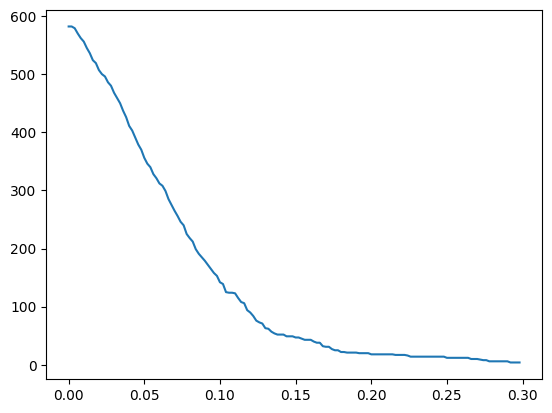

In [35]:
import numpy as np
import matplotlib.pyplot as plt


def min_1_count(df, v):
    df = df.loc[df[f'p_{measure}'] > v]
    return len(df['player_x'].unique())

x = np.arange(0.0, 0.3, 0.002)
y = []
for v in x:
    y.append(min_1_count(pairs, v))

plt.plot(x, y)
plt.show()

The drop off is continous/gradual and has no clear critical points to suggest a meaningful swap score. I will rank pair ratings for each player, and combine ranks in each pair to find mutually agreed pairs. Then I will plot them on a network graph.

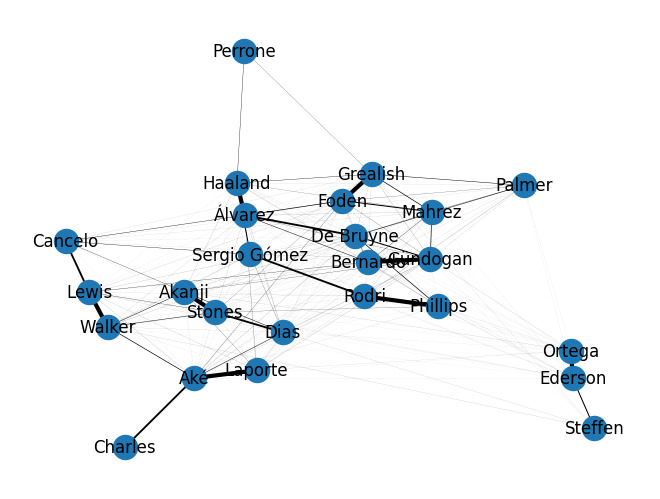

In [50]:
import networkx as nx

# Select a team
team_pairs = pairs.loc[pairs.team_x == 13].copy()

def plot_node_graph(df, p_measure):
    G = nx.Graph()
    for i, row in df.iterrows():
        G.add_edge(row['web_name_x'], row['web_name_y'], weight=row[p_measure])

    pos = nx.spring_layout(G, seed=5)
    weights = nx.get_edge_attributes(G, 'weight').values()
    
    nx.draw(G, pos, with_labels=True, width=3*np.array(list(weights)))
    plt.show()

# Get ranks and weights then plot node graph
team_pairs = team_pairs.loc[team_pairs[f'p_{measure}'] > 0]
team_pairs['pair_rank_x'] = team_pairs.groupby(['element_x'])[f'p_{measure}'].transform('rank', ascending=False).astype(int)
team_pairs['pair_rank_y'] = team_pairs.groupby(['element_y'])[f'p_{measure}'].transform('rank', ascending=False).astype(int)
team_pairs['pair_rank'] = (team_pairs['pair_rank_x'] + team_pairs['pair_rank_y']) / 2
team_pairs['weight'] = team_pairs['pair_rank'].apply(lambda x: 1/x**2)
plot_node_graph(team_pairs, 'weight')

If you know anything about Manchester City in 2022/23, you'd see that players who play in similar positions are closer together. This shows that secondary connections can also give insight into which players can intechange, even some pairs haven't interchanged much previously. Therefore, I am going to distribute the data into $n - 1$ (where $n$ is the number of players) dimensional space so that each pair is distanced geometrically according to the combined pair_rank.

In [41]:
# Your distance matrix
dist_mat = team_pairs.pivot(index='web_name_x', columns='web_name_y', values='pair_rank').fillna(0)

dist_mat

web_name_y,Akanji,Aké,Bernardo,Cancelo,Carson,Charles,De Bruyne,Delap,Dias,Ederson,...,Perrone,Phillips,Robertson,Rodri,Sergio Gómez,Steffen,Stones,Walker,Wilson-Esbrand,Álvarez
web_name_x,,,,,,,,,,,,,,,,,,,,,
Akanji,0.0,10.5,7.0,4.0,20.0,20.5,13.0,20.0,3.0,24.5,...,20.5,23.0,20.0,12.5,23.5,21.5,1.0,3.0,20.0,12.5
Aké,10.5,0.0,11.0,14.0,21.0,1.5,6.5,21.0,3.0,11.0,...,21.5,10.0,21.0,7.5,13.5,22.5,9.5,2.5,21.0,25.0
Bernardo,7.0,11.0,0.0,24.5,21.0,21.5,3.5,21.0,13.0,11.5,...,21.5,6.0,21.0,10.0,10.5,22.5,15.0,17.0,21.0,3.0
Cancelo,4.0,14.0,24.5,0.0,19.5,20.0,13.0,19.5,24.5,24.0,...,20.0,22.5,19.5,24.0,3.5,21.0,11.0,14.5,19.5,3.5
Carson,20.0,21.0,21.0,19.5,0.0,16.5,21.5,16.0,21.0,20.5,...,16.5,19.0,16.0,20.5,19.5,17.5,21.0,20.5,16.0,20.0
Charles,20.5,1.5,21.5,20.0,16.5,0.0,22.0,16.5,21.5,21.0,...,17.0,19.5,16.5,21.0,20.0,18.0,21.5,21.0,16.5,20.5
De Bruyne,13.0,6.5,3.5,13.0,21.5,22.0,0.0,21.5,17.5,15.0,...,22.0,2.5,21.5,16.5,8.0,23.0,10.0,13.0,21.5,1.5
Delap,20.0,21.0,21.0,19.5,16.0,16.5,21.5,0.0,21.0,20.5,...,16.5,19.0,16.0,20.5,19.5,17.5,21.0,20.5,16.0,20.0
Dias,3.0,3.0,13.0,24.5,21.0,21.5,17.5,21.0,0.0,17.0,...,21.5,13.5,21.0,25.5,5.0,8.5,1.5,9.5,21.0,8.0
